## Day 20 - MACD and trading strategy
MACD states for Moving Average Convergence Divergence. It is defined as the difference among the the short-term EMA (12 periods) and the long-term EMA (26 periods). So, as a consequence it will have a positive value when the short-term EMA is above the long-term one. Finally, the signal line is defined as a 9-EMA on the MACD values. 

$$ MACD = EMA_{w=12} - EMA_{w=26} $$

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [15]:
"""
    :param ticker: closing prices
    :param start: history start date
    :param end: history end date
    :return: stock's historical data 
"""
def get_data(ticker,start="2020-03-25"):
    return yf.download(ticker, start)

"""
    :param close: closing prices
    :param length: moving average length
    :return: stock's exponential moving average (EMA)
    
"""
def get_EMA(close,length):
    return close.ewm(span=length, adjust=False).mean()


"""
    :param close: closing prices
    :return MACD: MACD values
    :return signal: signal, calculated as a 9 day EMA on the MACD
"""
def get_MACD(close):
    macd =  get_EMA(close,12) - get_EMA(close,26)
    signal = get_EMA(macd,9)
    return signal, macd


In [34]:
stock_history  = get_data('TSLA','2020-03-06')
stock_close = stock_history['Adj Close']

signal, macd = get_MACD(stock_close)

[*********************100%***********************]  1 of 1 completed


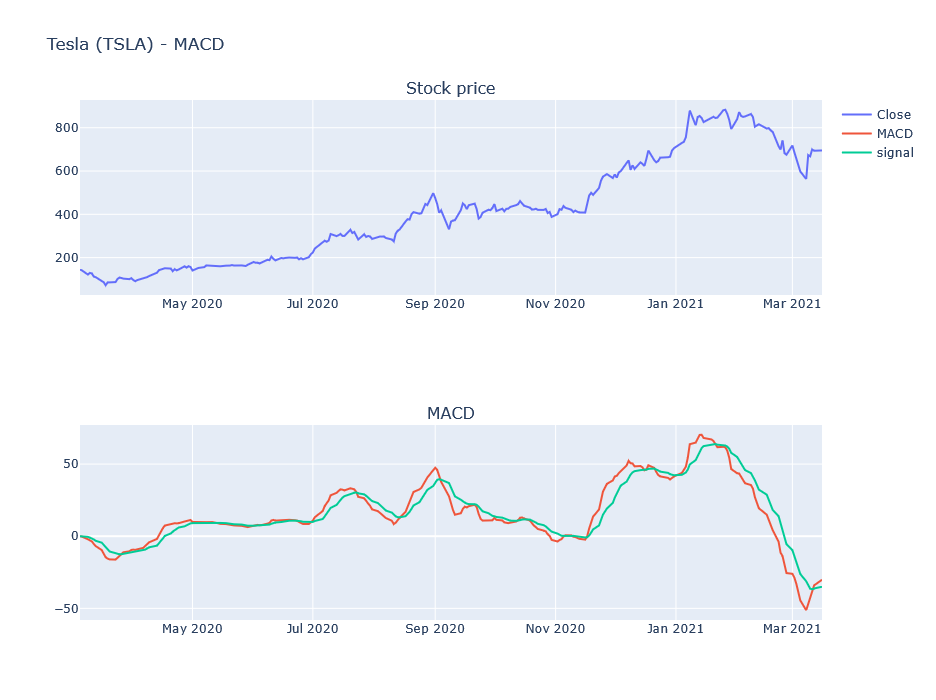

In [40]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Stock price", "MACD"))

fig.add_trace(go.Scatter(x=stock_close.index, y=stock_close, name='Close'), row=1, col=1)

fig.add_trace(go.Scatter(x=macd.index, y=macd, name='MACD'),row=2, col=1)
fig.add_trace(go.Scatter(x=signal.index, y=signal, name='signal'),row=2, col=1)


fig.update_layout(title_text="Tesla (TSLA) - MACD",height=700)
fig.show()

# static rendering for github
# fig.show("svg")

In [46]:
def trade_MACD(close,budget=10000):
    
    signal, macd = get_MACD(close)

    #st.markdown("<br /><br />",unsafe_allow_html=True)
    #lower_bound = st.slider("Select the oversold threshold (lower bound): ",0, 100, 30, 1)
    #upper_bound = st.slider("Select the overbought threshold (upper bound): ",0, 100, 70, 1)
    #st.markdown("<br /><br />",unsafe_allow_html=True)
    
    buy = []
    sell = []
    
    balance = budget 
    traded = 0
    traded_price = 0
    
    # pos = 0 : we do not have any position -> we can buy but we cannot sell
    # pos = 1 : we have a position -> we can sell and we cannot buy 
    
    # I am not considering trading fees
    # I suppose to trade the entire balance 
    pos = 0
    
    # update the profit every time I sell
    # I use another sell_list because I want to know also the final balance If it 
    # is still holding the last position
    sell_dates = []
    profit_values = []
    
    for i in range(1,len(close)-1):
        
        # buy
        if pos == 0 and macd[i] > signal[i]:
            
            buy.append(i)
            pos = 1
            
            # update balance
            traded_price = close[i]
            traded = balance
            balance = 0
        
        # sell signal
        elif pos == 1 and macd[i] < signal[i]:
            sell.append(i)
            pos = 0
            
            # update balance
            balance += traded * (close[i]/traded_price)
            
            # update profit
            sell_dates.append(i)
            profit_values.append(balance-budget)
            
    # final price
    if pos == 1:
        balance += traded * (close[len(close)-1]/traded_price)
        
        # update profit
        sell_dates.append(len(close)-1)
        profit_values.append(balance-budget)
        
    fig_macd = make_subplots(rows=2, cols=1, subplot_titles=("Stock price", "MACD"))
    fig_macd.add_trace(go.Scatter(x=close.index, y=close, name='Close'), row=1, col=1)
    fig_macd.add_trace(go.Scatter(x=close.iloc[buy].index, y=close.iloc[buy], name='Buy',
                          mode='markers', marker=dict(color='green', size=10, symbol='triangle-up')),row=1, col=1)
    fig_macd.add_trace(go.Scatter(x=close.iloc[sell].index, y=close.iloc[sell], name='Sell',
                            mode='markers', marker=dict(color='red', size=10, symbol='triangle-down')),row=1, col=1)
    

    fig_macd.add_trace(go.Scatter(x=macd.index, y=macd, name='MACD'),row=2, col=1)
    fig_macd.add_trace(go.Scatter(x=signal.index, y=signal, name='signal'),row=2, col=1)
    
    fig_macd.show()
    
    print(balance)

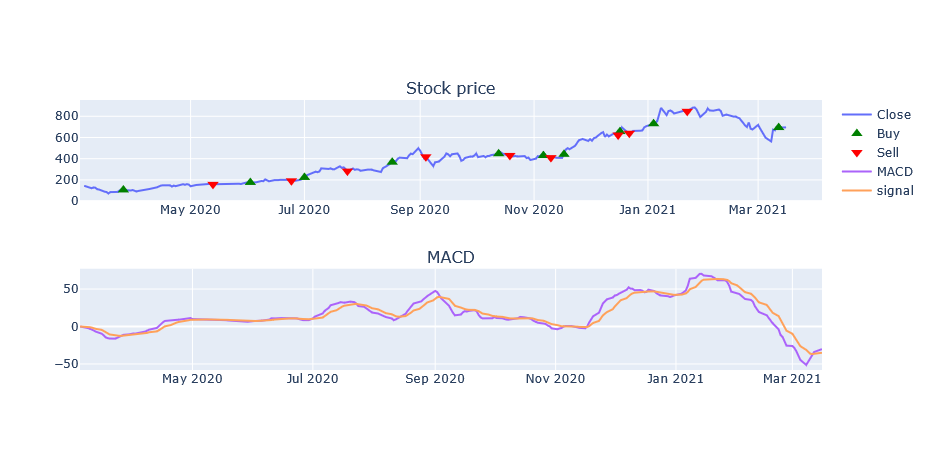

34680.87141471912


In [44]:
trade_MACD(stock_close,10000)